In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
import copy

In [7]:
N = 3
alpha = 0.01
gamma = 1
epochs = 200
p = 0.8
np.random.seed(0)

In [8]:
def rewardnstate(a, s):
    r, state, terminal = P[s][a]
    if s==1:
        r = r + np.random.uniform(-1, 1)
    return r, state, terminal

def act_functn(Q, state, state_visits, nAfes):
    #eps = 0.2
    #eps = 1/np.power(state_visits[state], 0.2)
    eps = 1/np.sqrt(state_visits[state])
    if np.random.choice([True, False], p=[1-eps, eps]):
        action = np.argmax(Q[state, :nAfes[state]])
    else:
        action = np.random.choice(nAfes[state])
    return action


In [10]:
def train(epochs, gamma, rewardnstate, act_functn, P, seed=0, alpha=0.05):
    def double_Qlearning(Qa, Qb,
                         cumsum, count,
                         count_matrix_a, maximal_value_a, 
                         maximal_value,
                         rewardnstate, action,
                         state, reward_list,
                         state_visits):
        reward, next_state, terminal = rewardnstate(action, state)
        cumsum += reward
        count += 1
        alpha_a = 1/np.power(count_matrix_a[state, action], p)
        action_star = np.argmax(Qa[next_state, :nAfes[next_state]])
        Qa[state, action] += alpha_a*(reward + gamma*Qb[next_state, action_star] - Qa[state, action])
        count_matrix_a[state, action] += 1
        state_visits[state] += 1
        maximal_value_a.append(np.max(Qa[start_state, :nAfes[start_state]]))
        maximal_value.append(np.max(Qa[start_state, :nAfes[start_state]]))
        reward_list.append((state, action, reward))
        return (reward_list, maximal_value_a,
                maximal_value, state_visits,
                count_matrix_a, Qa,
                next_state, terminal,
                cumsum, count)    
    
    def Qlearning(Qa, cumsum,
                  count, count_matrix_a,
                  maximal_value_a, maximal_value, 
                  rewardnstate,
                  action, state, reward_list,
                  state_visits):
        reward, next_state, terminal = rewardnstate(action, state)
        cumsum += reward
        count += 1
        alpha_a = 1/np.power(count_matrix_a[state, action], p)
        Qa[state, action] += alpha_a*(reward + gamma*np.max(Qa[next_state, :nAfes[next_state]]) - Qa[state, action])
        count_matrix_a[state, action] += 1
        state_visits[state] += 1
        maximal_value_a.append(np.max(Qa[start_state, :nAfes[start_state]]))
        maximal_value.append(np.max(Qa[start_state, :nAfes[start_state]]))
        reward_list.append((state, action, reward))
        return (reward_list, maximal_value_a,
                maximal_value, state_visits,
                count_matrix_a, Qa,
                next_state, terminal,
                cumsum, count)
    
    np.random.seed(seed)
    nS = 3
    nA = 8
    gamma = 1
    state_visits = np.ones(nS)
    maximal_value = []
    pref_list = []
    pref_learning_list = [] #0: double q learning, 1: q learning 
    cumsum = 0
    count = 0

    Q = [np.random.rand(nS, nA), np.random.rand(nS, nA)]
    Q[0][0] = 0
    Q[1][0] = 0
    count_matrix = [np.ones([nS, nA]), np.ones([nS, nA])]
    maximal_value_v = [[], []]
    nAfes = [1, 8, 2] #num_Actions_for_each_state
    start_state = 2
    avg_reward_per_step = []
    return_dict = {
            0: {0: []},
            1: {
                0: [], 1: [], 2: [],
                3: [], 4: [], 5: [],
                6: [], 7: []
            },
            2: {
                0: [], 1: []
            }
        }
    for i in range(epochs):
        reward_list = []
        state = start_state#state = np.random.choice(nS)
        terminal = True if state==0 else False
        choice = np.random.choice([True, False]).astype("int")
        
        while not terminal:
            action = act_functn(Q[choice], state, state_visits, nAfes)

            # Double Q learning is preferred if 
            #  we have more than 2 previous returns for a state action pair
            #  and the variance of return is less a threshold
            # In case either of the above two criteria are not followed
            # Q learning is preferred. 
            if(len(return_dict[state][action]) >= 2):
                if(stat.variance(return_dict[state][action])<0.23):
                    choice2 = np.random.choice([True, False]).astype("int")
                    
                    (reward_list, maximal_value_v[choice2],
                      maximal_value, state_visits,
                      count_matrix[choice2], Qc2, next_state,
                      terminal, cumsum, 
                     count) = double_Qlearning(Q[choice2], Q[1-choice2],
                                              cumsum, count,
                                              count_matrix[choice2], 
                                              maximal_value_v[choice2],
                                               maximal_value,
                                              rewardnstate, action,
                                              state, reward_list,
                                              state_visits)
                    Q[choice2] = Qc2
                    pref_learning_list.append(0)
                else:
                    
                    (reward_list, maximal_value_v[choice],
                    maximal_value, state_visits,
                    count_matrix[choice], Q[choice], next_state,
                    terminal, cumsum, count) = Qlearning(Q[choice], cumsum,
                                                          count, count_matrix[choice],
                                                          maximal_value_v[choice], 
                                                          maximal_value,
                                                          rewardnstate, action, 
                                                          state, reward_list,
                                                          state_visits)
                    pref_learning_list.append(1)
            else:
                
                (reward_list, maximal_value_v[choice],
                 maximal_value, state_visits,
                 count_matrix[choice], Q[choice], next_state,
                 terminal, cumsum, count) = Qlearning(Q[choice], cumsum,
                                                      count, count_matrix[choice],
                                                      maximal_value_v[choice], 
                                                      maximal_value,
                                                      rewardnstate, action, 
                                                      state, reward_list,
                                                      state_visits)
                pref_learning_list.append(1)
            state = next_state
            reward_sum = 0
            for i in range(len(reward_list)-1, -1, -1):
                reward_sum = gamma*reward_sum + reward_list[i][2]
                return_dict[reward_list[i][0]][reward_list[i][1]].append(reward_sum)

        pref = .0
        pref += Q[0][2][0] - Q[0][2][1] #preference of left over right
        pref += Q[1][2][0] - Q[1][2][1] #preference of left over right
        pref /= float(2)
        pref_list.append(pref)
        avg_reward_per_step.append(cumsum/count)
    return (avg_reward_per_step, pref_list, pref_learning_list, 
            Q[0], Q[1], maximal_value_v[0], maximal_value_v[1], 
            maximal_value, return_dict)

In [24]:
for i in [1, -1]:
    mu = i
    P = {
        0:{0: (0, 0, True)}, #state:{action: (reward, next state, terminal)}
        1:{0: (mu, 0, True),
           1: (mu, 0, True),
           2: (mu, 0, True),
           3: (mu, 0, True),
           4: (mu, 0, True),
           5: (mu, 0, True),
           6: (mu, 0, True),
           7: (mu, 0, True)}, 
        2:{0: (0, 1, False),
           1: (0, 0, True)}
    }
    (reward_list, pref_list,
     pref_learning_list, Qa,
     Qb, maximal_value_a,
     maximal_value_b, maximal_value,
     return_dict) = train(5000, gamma, rewardnstate, act_functn, P)
    print(pref_list[-1])

0.9964606531617048
-0.5036877713174344


# mu = 1, mu = -1
# 1.0461307081651836 -0.3180550969252852  1000 epochs
# 1.018252483260935   -0.4420569555814764  3000 epochs
# 0.9964606531617048 -0.5036877713174344  5000 epochs


In [18]:
pref_learning_array = np.array(pref_learning_list)
maximal_value_array = np.array(maximal_value)
qchosen = (pref_learning_array).nonzero()[0]
qchosen_maximal_value = maximal_value_array[qchosen]
dqchosen =(1-pref_learning_array).nonzero()[0]
dqchosen_maximal_value = maximal_value_array[dqchosen]
len(qchosen), len(qchosen_maximal_value), len(dqchosen), len(dqchosen_maximal_value)

(102, 102, 1957, 1957)

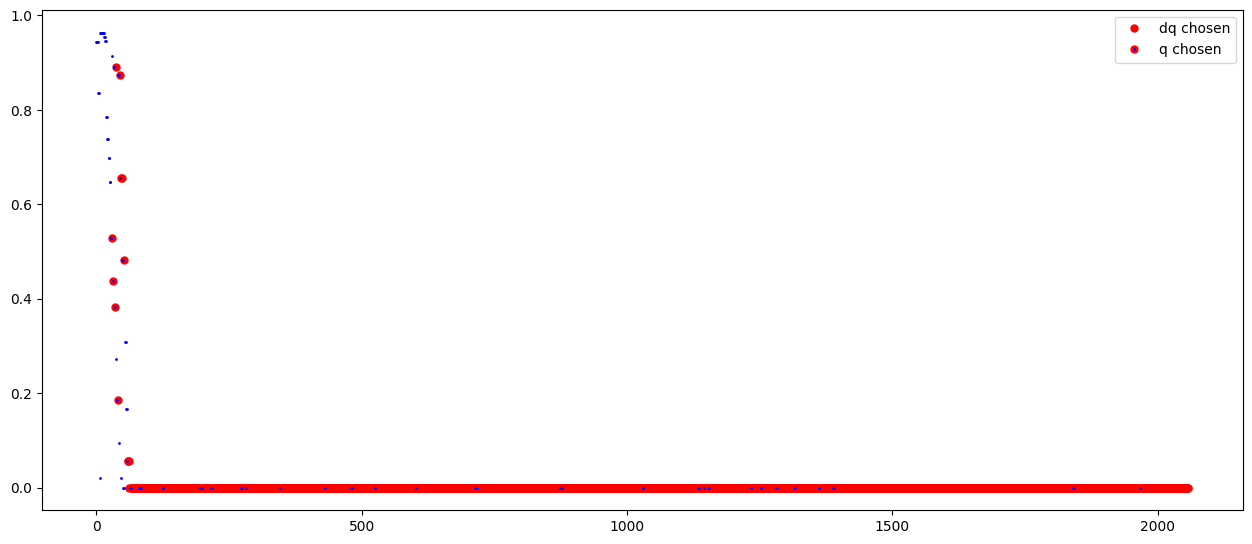

In [19]:
fig, ax = plt.subplots()
red_dot, = ax.plot(dqchosen, dqchosen_maximal_value, "ro", markersize=5)
blue_dot, = ax.plot(qchosen,qchosen_maximal_value, "bo",  markersize=1)

ax.legend([red_dot, (red_dot, blue_dot)], ["dq chosen", "q chosen"])
fig.set_size_inches(15.5, 6.5, forward=True)
plt.show()

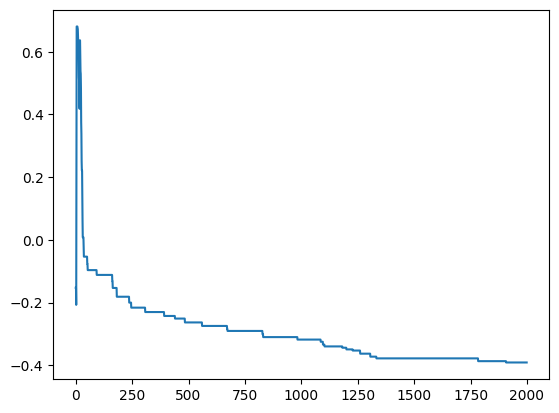

-0.3910998921190937

In [20]:
plt.plot(pref_list)
plt.show()

In [66]:
mu = -0.1
P = {
    0:{0: (0, 0, True)}, #state:{action: (reward, next state, terminal)}
    1:{0: (mu, 0, True),
       1: (mu, 0, True),
       2: (mu, 0, True),
       3: (mu, 0, True),
       4: (mu, 0, True),
       5: (mu, 0, True),
       6: (mu, 0, True),
       7: (mu, 0, True)}, 
    2:{0: (0, 1, False),
       1: (0, 0, True)}
}
(reward_list, pref_list,
 pref_learning_list, Qa,
 Qb, maximal_value_a,
 maximal_value_b, maximal_value,
 return_dict) = train(2000, gamma, rewardnstate, act_functn, P)

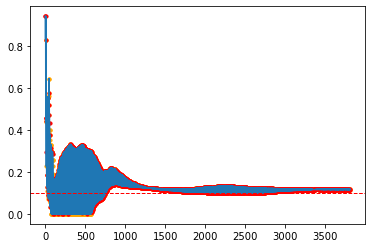

In [10]:
props = {
    "width": 1,
    "headwidth": 10
}
plt.scatter( dqchosen, dqchosen_maximal_value, s= 10, c = "orange")
plt.scatter(qchosen,qchosen_maximal_value, s= 10, c = "red" )
plt.plot(maximal_value)
plt.axhline(y = max(mu, 0), color = "r", linestyle = "--", linewidth = 1)
#plt.annotate('y = %s' % round(maximal_value[-1], 4), xy=(50000, maximal_value[-1]), xytext=(100000, 5), arrowprops = props)
plt.show()

In [9]:
def train2(epochs, gamma, rewardnstate, act_functn, P, seed=1, alpha=0.05):
    def double_Qlearning(Qa, Qb, cumsum, count, count_matrix_a, maximal_value_a, rewardnstate, action, state, reward_list, state_visits):
        reward, next_state, terminal = rewardnstate(action, state)
        cumsum += reward
        count += 1
        alpha_a = 1/np.power(count_matrix_a[state, action], p)
        action_star = np.argmax(Qa[next_state, :nAfes[next_state]])
        Qa[state, action] += alpha_a*(reward + gamma*Qb[next_state, action_star] - Qa[state, action])
        count_matrix_a[state, action] += 1
        state_visits[state] += 1
        maximal_value_a.append(np.max(Qa[start_state, :nAfes[start_state]]))
        maximal_value.append(np.max(Qa[start_state, :nAfes[start_state]]))
        reward_list.append((state, action, reward))
        return reward_list, maximal_value_a, maximal_value, state_visits, count_matrix_a, Qa, next_state, terminal, cumsum, count
    
    def Qlearning(Qa, cumsum, count, count_matrix_a, maximal_value_a, rewardnstate, action, state, reward_list, state_visits):
        reward, next_state, terminal = rewardnstate(action, state)
        cumsum += reward
        count += 1
        alpha_a = 1/np.power(count_matrix_a[state, action], p)
        Qa[state, action] += alpha_a*(reward + gamma*np.max(Qa[next_state, :nAfes[next_state]]) - Qa[state, action])
        count_matrix_a[state, action] += 1
        state_visits[state] += 1
        maximal_value_a.append(np.max(Qa[start_state, :nAfes[start_state]]))
        maximal_value.append(np.max(Qa[start_state, :nAfes[start_state]]))
        reward_list.append((state, action, reward))
        return reward_list, maximal_value_a, maximal_value, state_visits, count_matrix_a, Qa, next_state, terminal, cumsum, count
    
    np.random.seed(seed)
    nS = 3
    nA = 8
    gamma = 1
    count_matrix_a = np.ones([nS, nA])
    count_matrix_b = np.ones([nS, nA])
    state_visits = np.ones(nS)
    maximal_value_a = []
    maximal_value_b = []
    maximal_value = []
    pref_list = []
    pref_learning_list = []
    cumsum = 0
    count = 0
    Qa = np.random.rand(nS, nA)
    Qb = np.random.rand(nS, nA)
    Qa[0] = 0
    Qb[0] = 0
    print("Qa", Qa)
    nAfes = [1, 8, 2] #num_Actions_for_each_state
    start_state = 2
    return_dict = {
            0: {0: []},
            1: {
                0: [],
                1: [], 
                2: [],
                3: [],
                4: [],
                5: [],
                6: [],
                7: []
            },
            2: {
                0: [],
                1: []
            }
        }
    for i in range(epochs):
        reward_list = []
        state = start_state#state = np.random.choice(nS)
        terminal = True if state==0 else False
        while not terminal:
            if np.random.choice([True, False]):
                action = act_functn(Qa, state, state_visits, nAfes)
                try:
                    stat.variance(return_dict[state][action])
                    x = True
                except:
                    x = False
                if(x):
                    if(stat.variance(return_dict[state][action])<0.4):
                        (reward_list, maximal_value_a,
                         maximal_value, state_visits,
                         count_matrix_a, Qa,
                         next_state, terminal,
                         cumsum, count) = double_Qlearning(Qa, Qb,
                                                           cumsum, count,
                                                           count_matrix_a, maximal_value_a,
                                                           rewardnstate, action,
                                                           state, reward_list,
                                                           state_visits)
                        pref_learning_list.append(1)
                    else:
                        (reward_list, maximal_value_a,
                         maximal_value, state_visits,
                         count_matrix_a, Qa,
                         next_state, terminal,
                         cumsum, count) = Qlearning(Qa, cumsum,
                                                    count, count_matrix_a,
                                                    maximal_value_a, rewardnstate,
                                                    action, state, reward_list,
                                                    state_visits)
                        pref_learning_list.append(0)
                else:
                    (reward_list, maximal_value_a,
                     maximal_value, state_visits,
                     count_matrix_a, Qa,
                     next_state, terminal,
                     cumsum, count) = Qlearning(Qa, cumsum,
                                                count, count_matrix_a,
                                                maximal_value_a, rewardnstate,
                                                action, state,
                                                reward_list, state_visits)
                    pref_learning_list.append(0)

            else:
                action = act_functn(Qb, state, state_visits, nAfes)
                try:
                    stat.variance(return_dict[state][action])
                    x = True
                except:
                    x = False
                if(x):
                    if(stat.variance(return_dict[state][action])<0.4):
                        (reward_list, maximal_value_b,
                         maximal_value, state_visits,
                         count_matrix_b, Qb,
                         next_state, terminal,
                         cumsum, count) = double_Qlearning(Qb, Qa,
                                                           cumsum, count,
                                                           count_matrix_b, maximal_value_b,
                                                           rewardnstate, action,
                                                           state, reward_list,
                                                           state_visits)
                        pref_learning_list.append(1)
                    else:
                        (reward_list, maximal_value_b,
                         maximal_value, state_visits,
                         count_matrix_b, Qb,
                         next_state, terminal,
                         cumsum, count) = Qlearning(Qb, cumsum,
                                                    count, count_matrix_b,
                                                    maximal_value_b, rewardnstate,
                                                    action, state,
                                                    reward_list, state_visits)
                        pref_learning_list.append(0)
                else:
                    (reward_list, maximal_value_b,
                     maximal_value, state_visits,
                     count_matrix_b, Qb,
                     next_state, terminal,
                     cumsum, count) = Qlearning(Qb, cumsum,
                                                count, count_matrix_b,
                                                maximal_value_b, rewardnstate,
                                                action, state,
                                                reward_list, state_visits)

                    pref_learning_list.append(0)

            state = next_state
            reward_sum = 0
            for i in range(len(reward_list)-1, -1, -1):
                reward_sum = gamma*reward_sum + reward_list[i][2]
                return_dict[reward_list[i][0]][reward_list[i][1]].append(reward_sum)

        pref = .0
        pref += Qa[2][0] - Qa[2][1] #preference of left over right
        pref += Qb[2][0] - Qb[2][1] #preference of left over right
        pref /= float(2)
        pref_list.append(pref)
        reward_list.append(cumsum/count)
    return reward_list, pref_list, pref_learning_list, Qa, Qb, maximal_value_a, maximal_value_b, maximal_value, return_dict